This dataset is from kaggle: Bike Sharing Demand (https://www.kaggle.com/c/bike-sharing-demand/data?select=test.csv). This dataset is comprised of one train file and one test file, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The main goal of this project is to use different machine learning models to help fit the best model to predict the hourly demand for the test file. 

After data visualizations and simple feature selections. I split the train file into training dataset and testing dataset. Then I conducted linear regression, Lasso regression, Ridge regression, Decision tree repressor, random forest regressor as well as adaptive boosting to train the model. Meanwhile, I used GridSearchCV to help choose the best hyperparameters to improve the performances of models. Afterwards, I evaluated the performance of models based on the RMSE of the testing dataset and chose adaptive boosting model as the final model to predict the count in test file.

Import important packages

In [25]:
import numpy as np
import pandas as pd
import datetime #used to extract year, month, day, hour information from the datatime column
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

1. Overview of the dataset

For the train file, it is comprised of time series information, weather information as well as user count information. "casual" column represents number of non-registered user rentals initiated, "registered" represents number of registered user rentals initiated, while "count" is the total of "casual" and "registered".

In [3]:
#read the train file
df = pd.read_csv("Desktop/Bike/train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [5]:
#there does not exist null value in the dataset
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

2. Data Prepration

In [6]:
#Change columns to category types
categorylist = ["season","holiday","workingday","weather"]
for var in categorylist:
    df[var]=df[var].astype('category')
print(df.dtypes)

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object


In [7]:
#Extract year, month, day and hour
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['day']=pd.to_datetime(df['datetime']).dt.day
df['hour']=pd.to_datetime(df['datetime']).dt.hour
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [8]:
#Change columns to category types
categorylist = ["year","month","day","hour"]
for var in categorylist:
    df[var]=df[var].astype('category')

3. Data Visualization

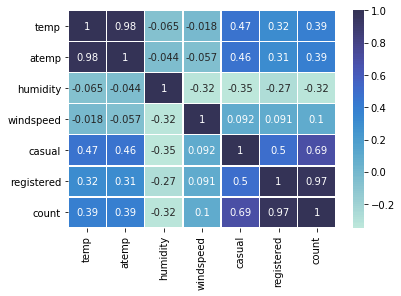

In [16]:
#correlation matrix:
corr = df[["temp","atemp","humidity","windspeed","casual","registered","count"]].corr()
sb.heatmap(corr,annot = True,linewidth = .5,center = 1.4)
#from the graph below:
#1. temp & atemp are highly correlated, we can just use one in the model
#2. windspeed's relationship with # of users is very weak, we can ignore it

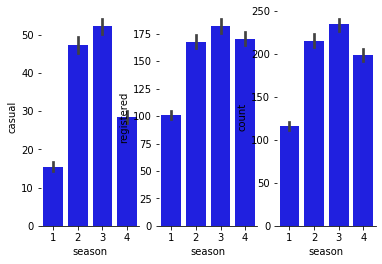

In [9]:
#season:
f,axes = plt.subplots(1,3)
sb.despine(left = True)
sb.barplot('season' ,'casual' , data = df, ax =  axes[0],color='blue')
sb.barplot('season','registered' , data = df, ax = axes[1],color='blue')
sb.barplot('season' ,'count' , data = df, ax = axes[2],color='blue')
#the graph below shows that in autumn and summer, there are much more bike sharing users

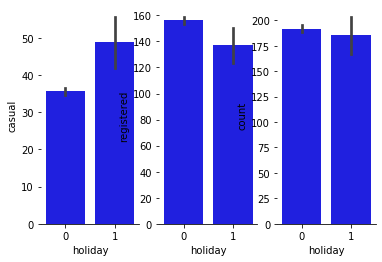

In [10]:
#holiday:
f,axes = plt.subplots(1,3)
sb.despine(left=True)
sb.barplot('holiday','casual',data=df,ax = axes[0],color='blue')
sb.barplot('holiday','registered',data=df,ax= axes[1],color='blue')
sb.barplot('holiday','count',data=df,ax= axes[2],color='blue')
#Overall, non-holiday users are larger than the holiday users
#however, for casual users, holiday users are larger,
#while for registered users, non-holiday users are larger

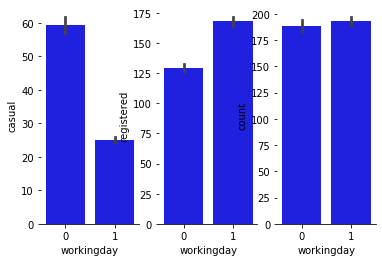

In [11]:
#working day:
f,axes = plt.subplots(1,3)
sb.despine(left=True)
sb.barplot('workingday','casual',data=df,ax=axes[0],color='blue')
sb.barplot('workingday','registered',data=df,ax=axes[1],color='blue')
sb.barplot('workingday','count',data=df,ax=axes[2],color='blue')

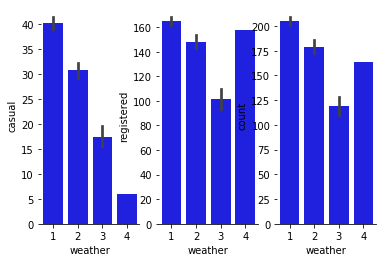

In [12]:
#weather:
f,axes=plt.subplots(1,3)
sb.despine(left=True)
sb.barplot('weather','casual',data=df,ax=axes[0],color='blue')
sb.barplot('weather','registered',data=df,ax=axes[1],color='blue')
sb.barplot('weather','count',data=df,ax=axes[2],color='blue')

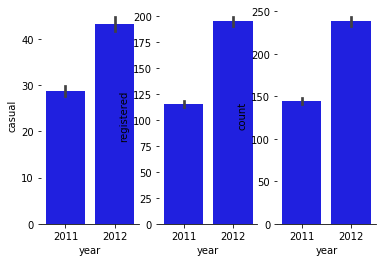

In [615]:
#year:
f,axes=plt.subplots(1,3)
sb.despine(left=True)
sb.barplot('year','casual',data=df,ax=axes[0],color='blue')
sb.barplot('year','registered',data=df,ax=axes[1],color='blue')
sb.barplot('year','count',data=df,ax=axes[2],color='blue')

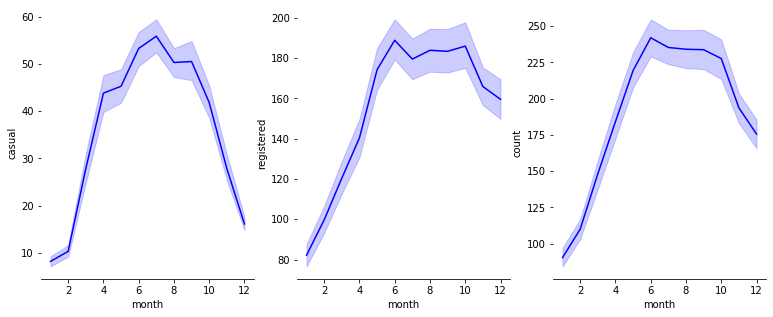

In [15]:
#month:
f,axes=plt.subplots(1,3,figsize = (13,5))
sb.despine(left=True)
sb.lineplot('month','casual',data=df,ax=axes[0],color='blue')
sb.lineplot('month','registered',data=df,ax=axes[1],color='blue')
sb.lineplot('month','count',data=df,ax=axes[2],color='blue')

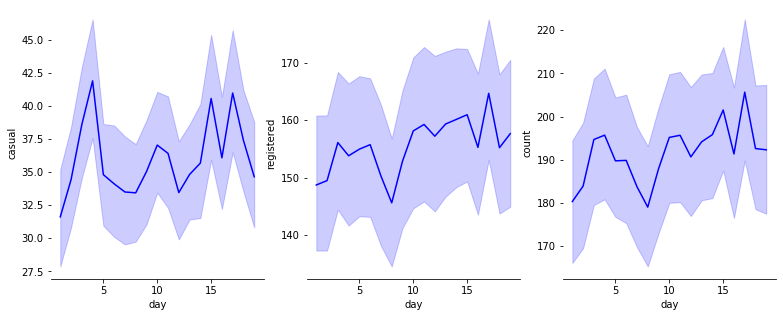

In [14]:
#day:
f,axes=plt.subplots(1,3,figsize = (13,5))
sb.despine(left=True)
sb.lineplot('day','casual',data=df,ax=axes[0],color='blue')
sb.lineplot('day','registered',data=df,ax=axes[1],color='blue')
sb.lineplot('day','count',data=df,ax=axes[2],color='blue')
#from this graph, we can see day has barely influence on the sharing bike using times

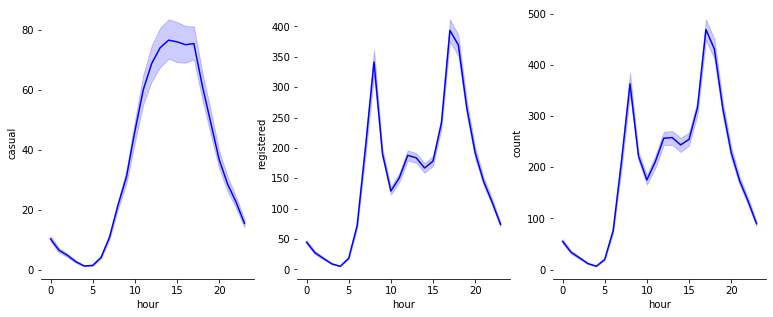

In [13]:
#hour:
f,axes=plt.subplots(1,3,figsize = (13,5))
sb.despine(left=True)
sb.lineplot('hour','casual',data=df,ax=axes[0],color='blue',markers=True)
sb.lineplot('hour','registered',data=df,ax=axes[1],color='blue',markers=True)
sb.lineplot('hour','count',data=df,ax=axes[2],color='blue',markers=True)
#we can notice that there exist two peaks in the total user number, one is at around 8 a.m. 
#and the other one is at around 17 p.m.. We can conclude that there is a pattern when users
#use sharing bike.

4. Modeling

In [17]:
#delete unnecessary columns
df = df.drop(columns=["atemp","windspeed","casual","registered"])
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,1,2011,1,1,4


In [19]:
#construct X matrix and y matrix for modelling
df.head()
X =df[["year","season","month","day","hour",
       "holiday","workingday","weather","temp",
      "humidity"]]
y =df["count"]

In [20]:
#split the train file into training dataset and testing dataset
#use 30% as the testing dataset and choose 42 as random_state
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

4.1 LinearRegression

In [21]:
linear = LinearRegression()
linear.fit(X_train,y_train)
y_pred = linear.predict(X_test)
R2_linear = linear.score(X_train,y_train)
MSE_linear = MSE(y_test,y_pred)
RMSE_linear = MSE_linear**0.5
print('The R^2 is: {:.3f}' .format(R2_linear))
print('The RMSE is: {:.3f}' .format(RMSE_linear))

The R^2 is: 0.388
The RMSE is: 141.343


4.2 Lasso

In [22]:
#create a pipeline
steps = [('scaler', StandardScaler()),
         ('lasso', Lasso())]
pipeline = Pipeline(steps)
#set param_grid for gridsearch
params = {'lasso__alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]}
gm_cv = GridSearchCV(pipeline, params,cv=5)
gm_cv.fit(X_train,y_train)
#optimal hyperparameter
print(gm_cv.best_params_)

{'lasso__alpha': 0.3}


In [23]:
#predict the count
y_pred = gm_cv.predict(X_test)
MSE_lasso = MSE(y_test,y_pred)
RMSE_lasso = MSE_lasso**0.5
R2_lasso = gm_cv.best_score_
print('The R^2 is: {:.3f}' .format(R2_lasso))
print('The RMSE is: {:.3f}' .format(RMSE_lasso))

The R^2 is: 0.386
The RMSE is: 141.375


4.3 Ridge

In [24]:
pipeline = Pipeline([('scaler',StandardScaler()),('ridge',Ridge())])
params = {'ridge__alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]}
gm_cv = GridSearchCV(pipeline,params,cv=5)
gm_cv.fit(X_train,y_train)
y_pred = gm_cv.predict(X_test)
MSE_ridge = MSE(y_test,y_pred)
RMSE_ridge = MSE_ridge**0.5
R2_ridge = gm_cv.best_score_
print(gm_cv.best_params_)
print('The R^2 is: {:.3f}' .format(R2_ridge))
print('The RMSE is: {:.3f}' .format(RMSE_ridge)) 

{'ridge__alpha': 30}
The R^2 is: 0.386
The RMSE is: 141.356


4.4 CART

In [26]:
#choose max_depth = 5 and min_samples_leaf = 0.1 to run a tree model
tree = DecisionTreeRegressor(max_depth=5,min_samples_leaf=0.1,
                            random_state=42)
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
MSE_cart = MSE(y_test,y_pred)
RMSE_cart = MSE_cart**0.5
print('The RMSE is: {:.3f}' .format(RMSE_cart)) 

The RMSE is: 125.462


In [28]:
#use gridsearch to choose the hyperparameter
params = {'max_depth':[1,3,5,7,9],
         'min_samples_leaf':[0.02,0.04,0.08,0.12,0.16,0.2]}
gm_cv = GridSearchCV(tree,params,cv=5)
gm_cv.fit(X_train,y_train)
y_pred = gm_cv.predict(X_test)
RMSE_cartgrid = MSE(y_test,y_pred)**0.5
print(gm_cv.best_params_)
print('The RMSE is {:.3f}'.format(RMSE_cartgrid))
#the optimal CART model improves a lot in terms of RMSE compared to linear model
#the RMSE decreases from 140 to 100

{'max_depth': 9, 'min_samples_leaf': 0.02}
The RMSE is 100.022


4.5 Random Forest

In [29]:
#choose max_depth = 9, min_samples_leaf = 0.02 and n_estimators=200 to run a random forest model
rf = RandomForestRegressor(max_depth=9,min_samples_leaf=0.02,n_estimators=200)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
RMSE_rf = MSE(y_test,y_pred)**0.5
print('The RMSE is {:.3f}'.format(RMSE_rf))

The RMSE is 99.822


In [30]:
#use gridsearch to choose optimal hyperparameters
#this line of code takes a while (~10 mintues) to run
params = {'max_depth':[3,5,7,9,11,13],
         'min_samples_leaf':[0.02,0.04,0.08,0.12,0.16,0.2],
         'n_estimators':[100,250,500,1000]}
gm_cv = GridSearchCV(rf,params,cv=3)
gm_cv.fit(X_train,y_train)
y_pred = gm_cv.predict(X_test)
print(gm_cv.best_params_)
RMSE_rfgrid = MSE(y_test,y_pred)**0.5
print('The RMSE is {:.3f}'.format(RMSE_rfgrid))

{'max_depth': 11, 'min_samples_leaf': 0.02, 'n_estimators': 100}
The RMSE is 100.876


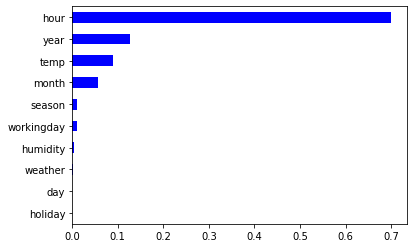

In [31]:
#feature importance for random forest
best_model = gm_cv.best_estimator_
best_model.feature_importances_
importances = pd.Series(best_model.feature_importances_,index=X.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='blue')
plt.show()
#it is shown in the graph below that hour plays a huge important role in the random forest model

4.6 Adaptive Boosting

In [32]:
boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                          n_estimators=200,random_state=42)
boost.fit(X_train,y_train)
y_pred = boost.predict(X_test)
RMSE_adab = MSE(y_test,y_pred)**0.5
print('The RMSE is {:.3f}'.format(RMSE_adab))

The RMSE is 43.954


In [33]:
#gridsearch for optimal hyperparameters
param_dist = {
 'n_estimators': [100,200,500],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }
rs_cv = RandomizedSearchCV(boost,param_dist,cv=3) #in order to decrease running time, i used randomizedsearchcv here instead of gridsearch
rs_cv.fit(X_train,y_train)
y_pred = rs_cv.predict(X_test)
RMSE_adagrid = MSE(y_test,y_pred)**0.5
print(rs_cv.best_params_)
print('The RMSE is {:.3f}'.format(RMSE_adagrid))

{'n_estimators': 200, 'loss': 'square', 'learning_rate': 0.3}
The RMSE is 45.946


4.6 Model selection

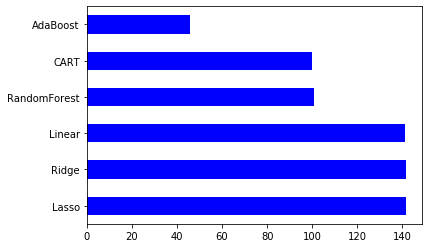

In [35]:
model = ["Linear","Lasso","Ridge","CART","RandomForest","AdaBoost"]
RMSE = [RMSE_linear,RMSE_lasso,RMSE_ridge,RMSE_cartgrid,RMSE_rfgrid,RMSE_adagrid]
rmseseries = pd.Series(RMSE,index=model)
rmseseries_sorted = rmseseries.sort_values(ascending=True) 
rmseseries_sorted.plot(kind="barh",color="blue").invert_yaxis()

5. Prediciton on test file

In [36]:
#read the test file
test = pd.read_csv("Desktop/Bike/test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [37]:
#extract year, month, day, hour information from datatime
test['year'] = pd.to_datetime(test['datetime']).dt.year
test['month'] = pd.to_datetime(test['datetime']).dt.month
test['day']=pd.to_datetime(test['datetime']).dt.day
test['hour']=pd.to_datetime(test['datetime']).dt.hour

In [38]:
#drop unrelated columns
testx = test.drop(columns=["datetime","windspeed","atemp"])
testx.head()

,season,holiday,workingday,weather,temp,humidity,year,month,day,hour
0,1,0,1,1,10.66,56,2011,1,20,0
1,1,0,1,1,10.66,56,2011,1,20,1
2,1,0,1,1,10.66,56,2011,1,20,2
3,1,0,1,1,10.66,56,2011,1,20,3
4,1,0,1,1,10.66,56,2011,1,20,4


In [39]:
#examine the null value
testx.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
humidity      0
year          0
month         0
day           0
hour          0
dtype: int64

In [40]:
#change the column data types to category
category = ["season","holiday","workingday","weather","year","month","day","hour"]
for var in category:
    testx[var] = testx[var].astype("category")

In [41]:
#construct test X matrix
X_new = testx[["year","season","month","day","hour","holiday","workingday","weather","temp","humidity"]]

In [43]:
#use the adaptive boosting model to predict
testx['pred'] = rs_cv.predict(X_new)
testx['pred'] = np.round(testx['pred'])
testx['datetime'] = test['datetime']
final_submission = testx[["datetime","pred"]]
final_submission = final_submission.rename(columns={'pred':'count'})
final_submission.head(24)

,datetime,count
0,2011-01-20 00:00:00,14.0
1,2011-01-20 01:00:00,6.0
2,2011-01-20 02:00:00,4.0
3,2011-01-20 03:00:00,3.0
4,2011-01-20 04:00:00,3.0
5,2011-01-20 05:00:00,8.0
6,2011-01-20 06:00:00,34.0
7,2011-01-20 07:00:00,88.0
8,2011-01-20 08:00:00,202.0
9,2011-01-20 09:00:00,124.0
